In [ ]:
! git clone https://github.com/gupta1912/ERA-V1-Assignments.git

Cloning into 'ERA-V1-Assignments'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 102 (delta 25), reused 87 (delta 13), pack-reused 0
Receiving objects: 100% (102/102), 2.13 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
cd ERA-V1-Assignments/S10

/content/ERA-V1-Assignments/S10


In [ ]:
!pip install torchinfo
!pip install torch-lr-finder

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch_lr_finder import LRFinder
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from model import MyResNet
from utils import CustomResnetTransforms, imshow, train, test, plot_curves
from dataloader import Cifar10SearchDataset
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
train_set = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_set = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 67763197.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

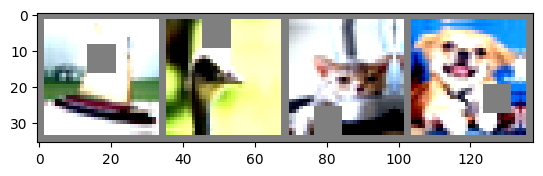

ship  bird  cat   dog  


In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
from torchinfo import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MyResNet().to(device)
summary(model, input_size=(512, 3, 32, 32))

cuda


Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [512, 10]                 --
├─Sequential: 1-1                        [512, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─ReLU: 2-3                         [512, 64, 32, 32]         --
├─Sequential: 1-2                        [512, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [512, 128, 32, 32]        73,856
│    └─MaxPool2d: 2-5                    [512, 128, 16, 16]        --
│    └─BatchNorm2d: 2-6                  [512, 128, 16, 16]        256
│    └─ReLU: 2-7                         [512, 128, 16, 16]        --
├─ResBlock: 1-3                          [512, 128, 16, 16]        --
│    └─Sequential: 2-8                   [512, 128, 16, 16]        --
│    │    └─Conv2d: 3-1                  [512, 128, 16, 16]        147,456
│

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.22E-02


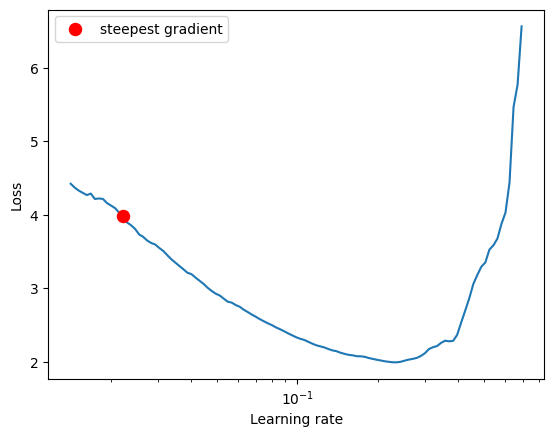

In [ ]:
model = MyResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
model =  MyResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
EPOCHS = 24
scheduler = OneCycleLR(
        optimizer,
        max_lr = 2.22E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)


Epoch 1


Train: Loss=0.8687 Batch_id=97 Accuracy=54.28: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0024, Accuracy: 6015/10000 (60.15%)

Epoch 2


Train: Loss=0.7688 Batch_id=97 Accuracy=70.54: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0016, Accuracy: 7345/10000 (73.45%)

Epoch 3


Train: Loss=0.6028 Batch_id=97 Accuracy=75.31: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0019, Accuracy: 7009/10000 (70.09%)

Epoch 4


Train: Loss=0.6672 Batch_id=97 Accuracy=77.02: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6759/10000 (67.59%)

Epoch 5


Train: Loss=0.5786 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0022, Accuracy: 6698/10000 (66.98%)

Epoch 6


Train: Loss=0.5364 Batch_id=97 Accuracy=81.36: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0011, Accuracy: 8041/10000 (80.41%)

Epoch 7


Train: Loss=0.5822 Batch_id=97 Accuracy=83.17: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]


Test set: Average loss: 0.0016, Accuracy: 7402/10000 (74.02%)

Epoch 8


Train: Loss=0.5130 Batch_id=97 Accuracy=83.95: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0012, Accuracy: 7971/10000 (79.71%)

Epoch 9


Train: Loss=0.4844 Batch_id=97 Accuracy=84.63: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0011, Accuracy: 8060/10000 (80.60%)

Epoch 10


Train: Loss=0.4243 Batch_id=97 Accuracy=85.18: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0013, Accuracy: 7918/10000 (79.18%)

Epoch 11


Train: Loss=0.4272 Batch_id=97 Accuracy=85.75: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0010, Accuracy: 8386/10000 (83.86%)

Epoch 12


Train: Loss=0.4731 Batch_id=97 Accuracy=85.84: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0012, Accuracy: 7997/10000 (79.97%)

Epoch 13


Train: Loss=0.4053 Batch_id=97 Accuracy=87.09: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8429/10000 (84.29%)

Epoch 14


Train: Loss=0.3486 Batch_id=97 Accuracy=87.12: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0009, Accuracy: 8390/10000 (83.90%)

Epoch 15


Train: Loss=0.3302 Batch_id=97 Accuracy=87.97: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0008, Accuracy: 8591/10000 (85.91%)

Epoch 16


Train: Loss=0.3019 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0009, Accuracy: 8452/10000 (84.52%)

Epoch 17


Train: Loss=0.2836 Batch_id=97 Accuracy=88.86: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]


Test set: Average loss: 0.0009, Accuracy: 8461/10000 (84.61%)

Epoch 18


Train: Loss=0.3327 Batch_id=97 Accuracy=89.74: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0008, Accuracy: 8636/10000 (86.36%)

Epoch 19


Train: Loss=0.2531 Batch_id=97 Accuracy=90.46: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0007, Accuracy: 8926/10000 (89.26%)

Epoch 20


Train: Loss=0.2378 Batch_id=97 Accuracy=91.54: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0006, Accuracy: 8924/10000 (89.24%)

Epoch 21


Train: Loss=0.1610 Batch_id=97 Accuracy=92.66: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0006, Accuracy: 9033/10000 (90.33%)

Epoch 22


Train: Loss=0.1740 Batch_id=97 Accuracy=94.12: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0005, Accuracy: 9124/10000 (91.24%)

Epoch 23


Train: Loss=0.1381 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0005, Accuracy: 9238/10000 (92.38%)

Epoch 24


Train: Loss=0.1343 Batch_id=97 Accuracy=96.78: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]


Test set: Average loss: 0.0004, Accuracy: 9292/10000 (92.92%)



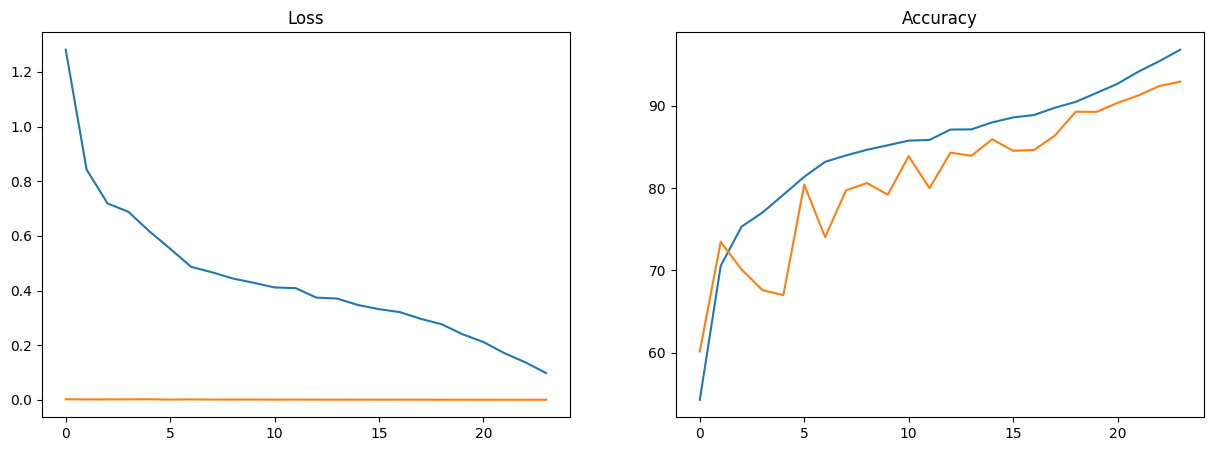

In [ ]:
plot_curves(train_losses, train_acc, test_losses, test_acc)